In [41]:
import pandas as pd
import numpy as np

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases

#spacy
import spacy

# from stop_words import get_stop_words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

#vis
import pyLDAvis
import pyLDAvis.gensim_models

# Load & Validate Data

In [42]:
df=pd.read_csv("Womens Clothing E-Commerce Reviews.csv")

In [43]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [45]:
df.isnull().sum()

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [46]:
df.fillna({"Title": "","Review Text":"","Department Name":df["Department Name"].mode()[0],"Division Name":df["Division Name"].mode()[0],"Class Name":df["Class Name"].mode()[0]},inplace=True)

df.isnull().sum()

Unnamed: 0                 0
Clothing ID                0
Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
dtype: int64

# Preprocess Datanize

## Tokenize

In [47]:
# create a generator function to create tokens from each doc(each review) in the dataframe
df['tokenized_review'] = df['Review Text'].apply(lambda x: simple_preprocess(str(x),deacc=True))


## Stop Word Removal

In [48]:
stop_words = stopwords.words('english') + list(string.punctuation)+['dress',"would"]

In [49]:
def rem_stop_words(tokens):
    filtered_tokens = [word.lower() for word in tokens if word.lower() not in stop_words]
    return filtered_tokens

In [50]:
df['tokenized_review']=df['tokenized_review'].apply(lambda x: rem_stop_words(x))
df['tokenized_review'].head()

0    [absolutely, wonderful, silky, sexy, comfortable]
1    [love, sooo, pretty, happened, find, store, gl...
2    [high, hopes, really, wanted, work, initially,...
3    [love, love, love, jumpsuit, fun, flirty, fabu...
4    [shirt, flattering, due, adjustable, front, ti...
Name: tokenized_review, dtype: object

## Lemmatization

In [51]:
# create function for above to apply on tokenized_reviews
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(tokens,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    tokens_out=[]
    doc=nlp("".join(tokens))
    tokens_out=[token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return tokens_out

In [52]:
df['lemmatized_reviews'] = df['tokenized_review'].apply(lambda x: lemmatization(x))


# Topic Modelling using LDA

In [53]:
# Create Corpus of preprocessed tokens - list of token lists
data_words=df['tokenized_review'].tolist()
print(data_words[2:5])

[['high', 'hopes', 'really', 'wanted', 'work', 'initially', 'ordered', 'petite', 'small', 'usual', 'size', 'found', 'outrageously', 'small', 'small', 'fact', 'could', 'zip', 'reordered', 'petite', 'medium', 'ok', 'overall', 'top', 'half', 'comfortable', 'fit', 'nicely', 'bottom', 'half', 'tight', 'layer', 'several', 'somewhat', 'cheap', 'net', 'layers', 'imo', 'major', 'design', 'flaw', 'net', 'layer', 'sewn', 'directly', 'zipper'], ['love', 'love', 'love', 'jumpsuit', 'fun', 'flirty', 'fabulous', 'every', 'time', 'wear', 'get', 'nothing', 'great', 'compliments'], ['shirt', 'flattering', 'due', 'adjustable', 'front', 'tie', 'perfect', 'length', 'wear', 'leggings', 'sleeveless', 'pairs', 'well', 'cardigan', 'love', 'shirt']]


In [54]:
# create dictionary and corpus
id2word=corpora.Dictionary(data_words)
corpus=[id2word.doc2bow(text) for text in data_words]
print(corpus[2:4])

[[(1, 1), (19, 1), (20, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 3), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1)], [(15, 3), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1)]]


In [55]:
print(list(id2word.token2id.items())[20:30])

[('petite', 20), ('pretty', 21), ('someone', 22), ('sooo', 23), ('store', 24), ('true', 25), ('truly', 26), ('bottom', 27), ('cheap', 28), ('could', 29)]


In [56]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=.1,
                                           per_word_topics=True)

In [57]:
import pprint
pprint.pprint(lda_model.print_topics())

[(0,
  '0.054*"sweater" + 0.030*"black" + 0.016*"lightweight" + 0.016*"knit" + '
  '0.011*"extremely" + 0.011*"sold" + 0.011*"already" + 0.011*"wardrobe" + '
  '0.010*"heels" + 0.010*"sleeves"'),
 (1,
  '0.075*"size" + 0.041*"small" + 0.024*"fit" + 0.022*"ordered" + 0.021*"wear" '
  '+ 0.021*"large" + 0.017*"petite" + 0.016*"xs" + 0.016*"usually" + '
  '0.013*"perfectly"'),
 (2,
  '0.029*"waist" + 0.013*"shoulders" + 0.011*"around" + 0.011*"fit" + '
  '0.009*"tight" + 0.009*"high" + 0.009*"hips" + 0.009*"happy" + '
  '0.008*"flattering" + 0.008*"chest"'),
 (3,
  '0.030*"like" + 0.021*"top" + 0.016*"fabric" + 0.014*"really" + 0.014*"look" '
  '+ 0.013*"back" + 0.012*"much" + 0.010*"nice" + 0.010*"material" + '
  '0.010*"looks"'),
 (4,
  '0.036*"love" + 0.027*"great" + 0.020*"wear" + 0.015*"perfect" + '
  '0.015*"comfortable" + 0.014*"color" + 0.014*"soft" + 0.012*"jeans" + '
  '0.012*"bought" + 0.011*"flattering"')]


In [58]:
# coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4212944137350517


IndexError: list index out of range

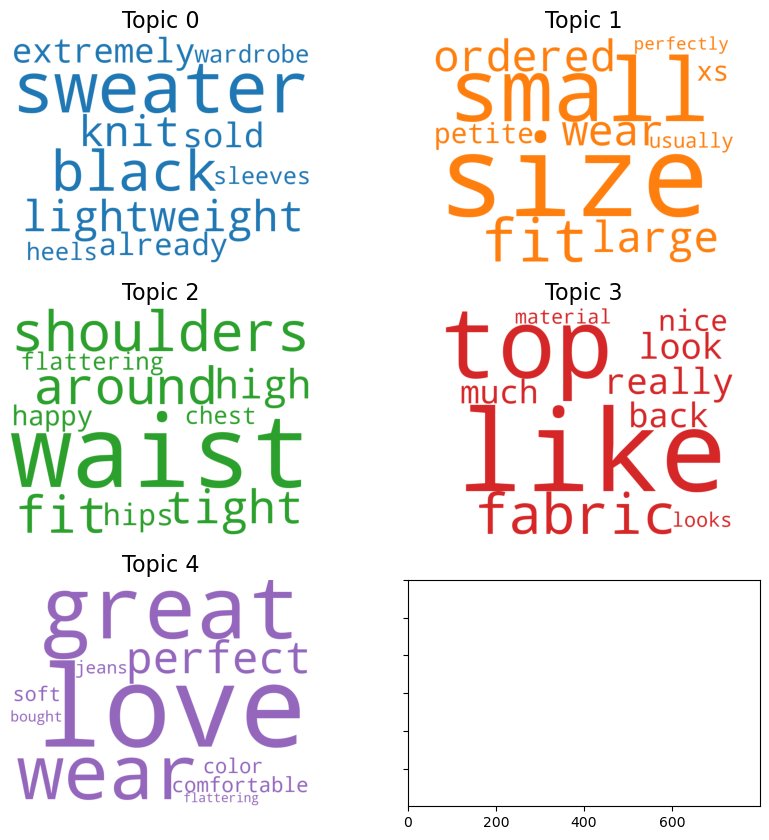

In [59]:

# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=800,
                  height=600,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

C:\Users\agaan\AppData\Local\Temp\ipykernel_33800\4192044188.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\agaan\AppData\Local\Temp\ipykernel_33800\4192044188.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\agaan\AppData\Local\Temp\ipykernel_33800\4192044188.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
C:\Users\agaan\AppData\Local\Temp\ipykernel_33800\4192044188.py:24: UserWarning: set_ticklabels() should only be used with a

Text(0.5, 1.05, 'Word Count and Importance of Topic Keywords')

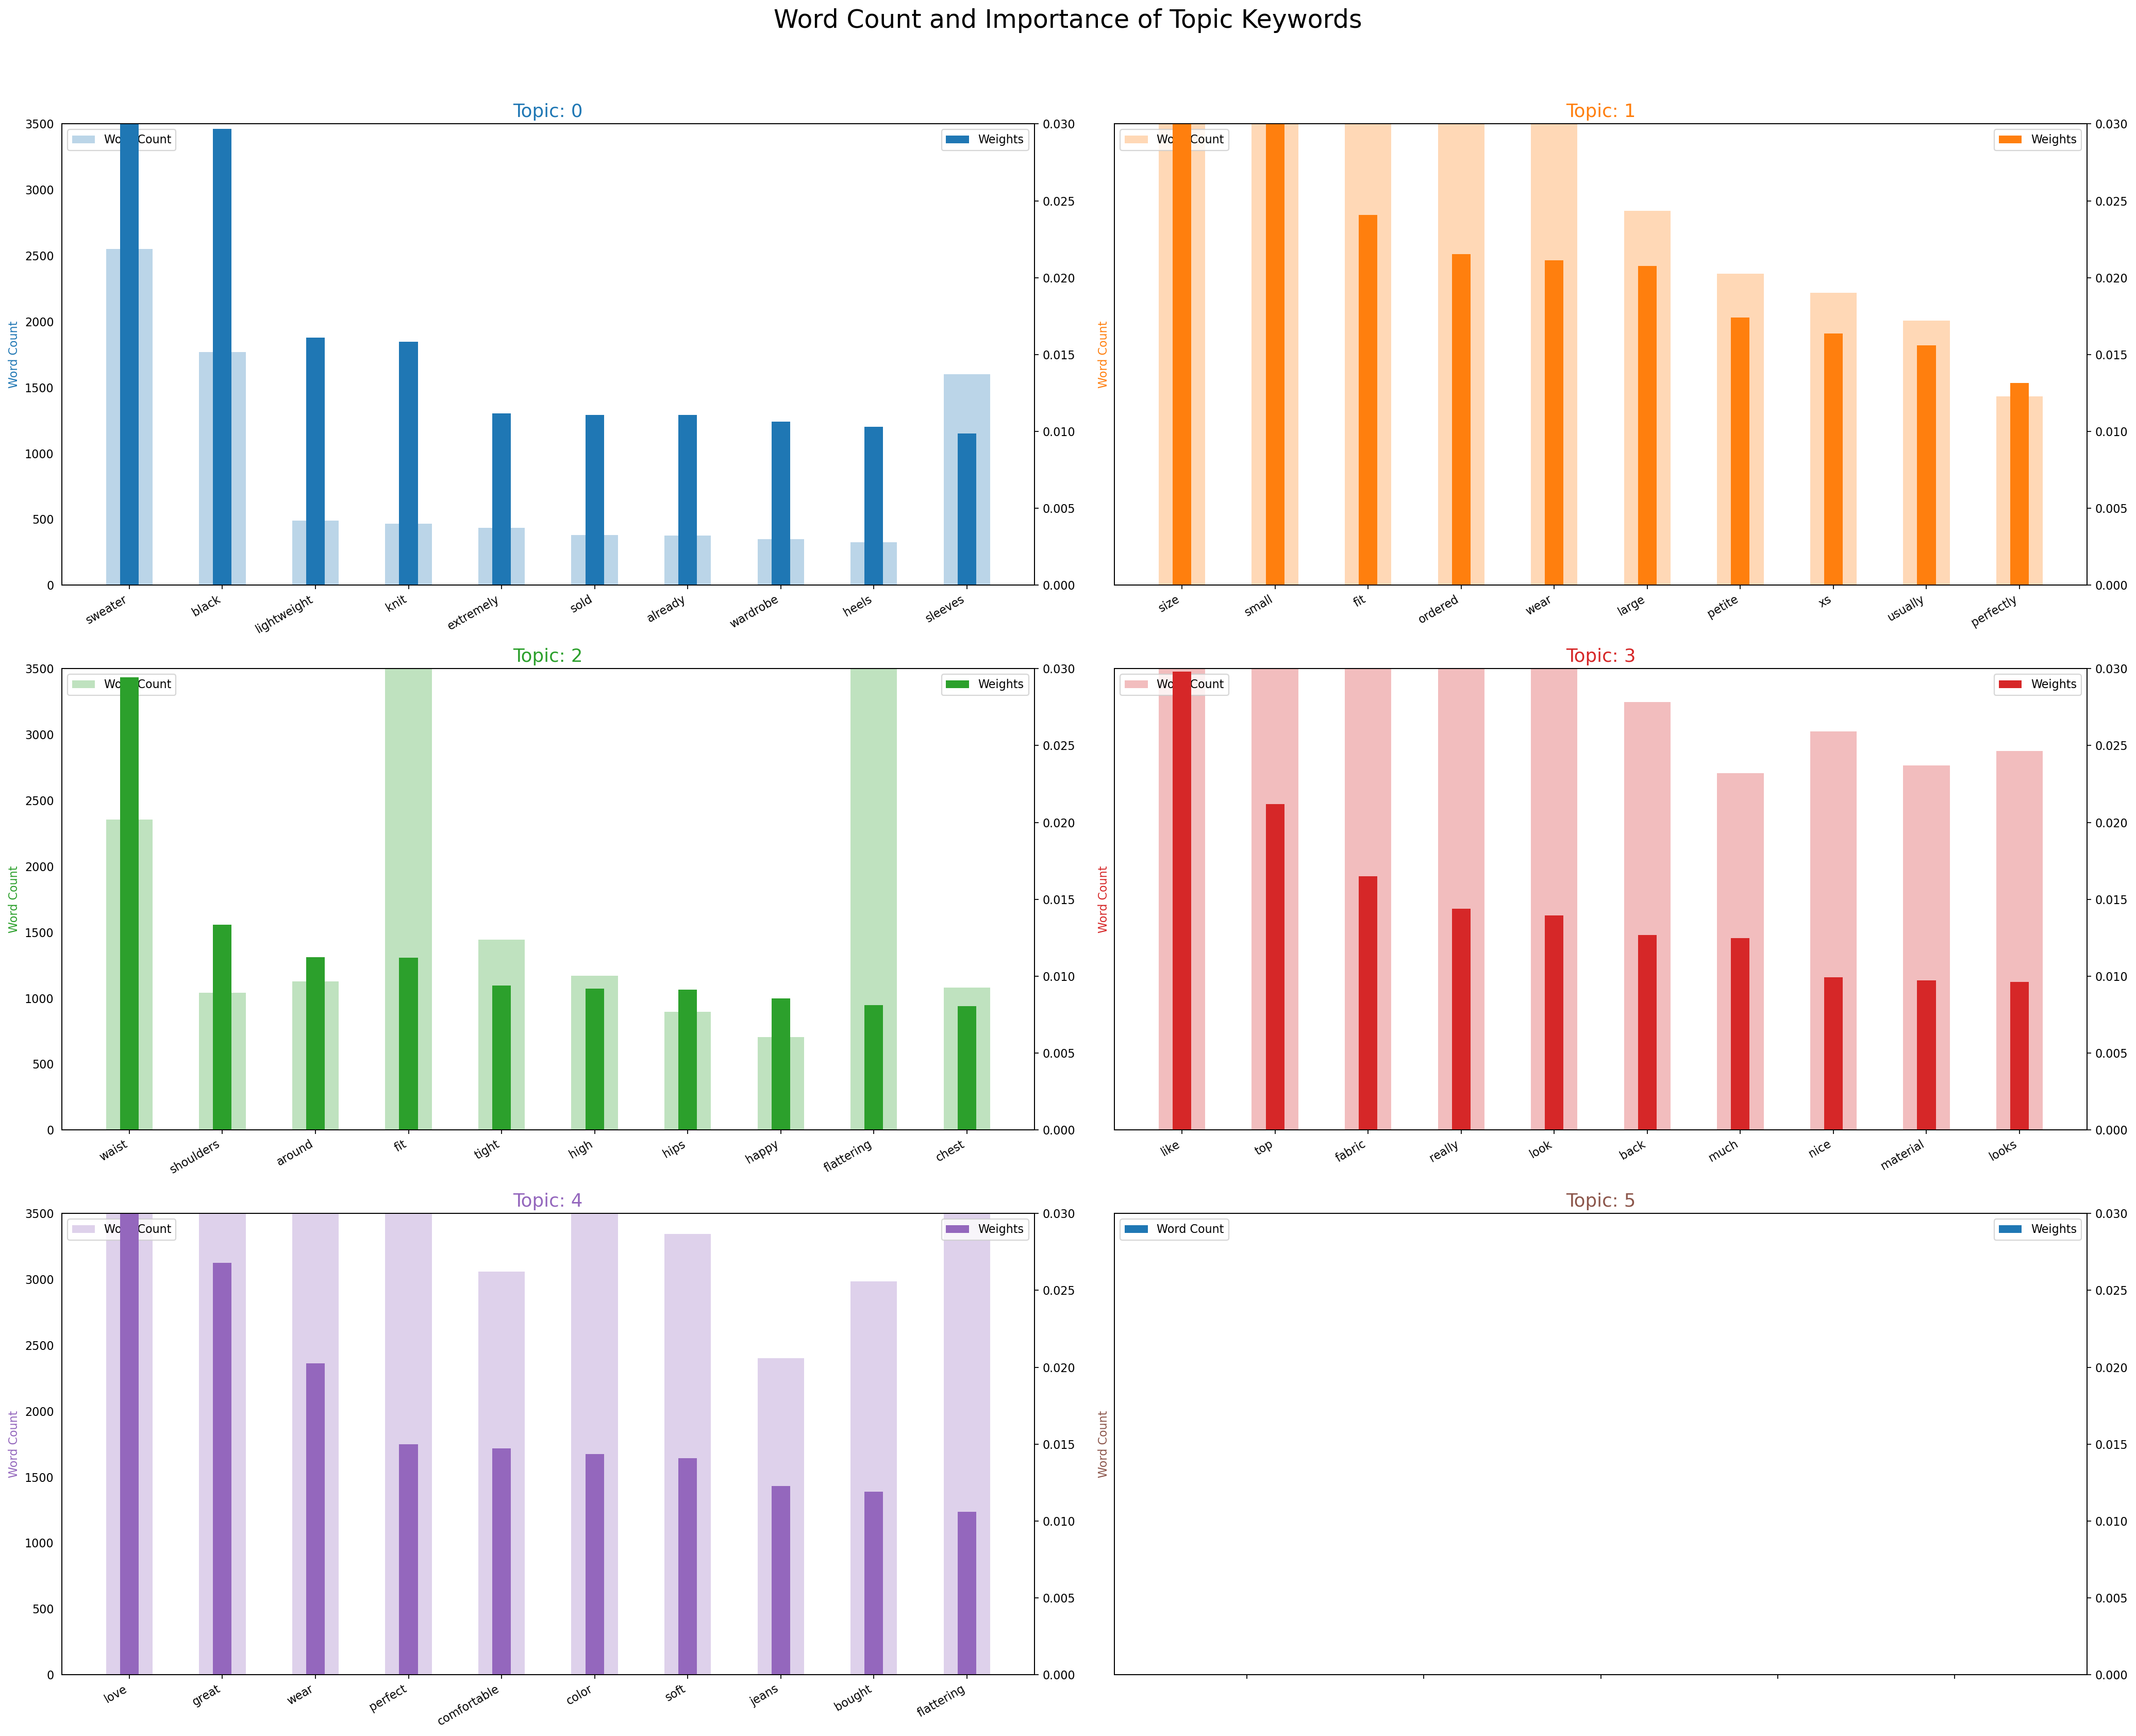

In [60]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_words for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(26,20), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)

In [61]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.173886 -0.047094       1        1  31.229486
3      0.191282 -0.039804       2        1  29.870004
1      0.064621 -0.178872       3        1  19.144127
2     -0.020236  0.349865       4        1  13.771252
0     -0.409553 -0.084095       5        1   5.985129, topic_info=          Term         Freq        Total Category  logprob  loglift
54        size  8858.000000  8858.000000  Default  30.0000  30.0000
55       small  5168.000000  5168.000000  Default  29.0000  29.0000
442    sweater  2845.000000  2845.000000  Default  28.0000  28.0000
287      waist  2512.000000  2512.000000  Default  27.0000  27.0000
74        wear  6426.000000  6426.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
578      cream   248.145220   355.397036   Topic5  -5.0070   2.4567
170    sleeves   365.904677  1886.540570   Topic5  -4.6186   1.1758
353        new   267.817601   520.238669   Topic5  -4.9307   2.1519
76    cardigan   255.180328   442.280381   Topic5  -4.9790   2.2659
619  recommend   234.636387   971.734703   Topic5  -5.0630   1.3948

[304 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.999160  absolutely
1607      5  0.998036    addition
622       4  0.478228    adorable
622       5  0.520210    adorable
1292      4  0.997969       agree
...     ...       ...         ...
149       2  0.076496          xs
149       3  0.923179          xs
178       2  0.998321         xxs
217       5  0.998234        year
63        4  0.998635      zipper

[400 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 3, 1])